<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/magic1.jpg?raw=1" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/shower.jpg?raw=1" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/geo.jpg?raw=1" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/gamma_p.png?raw=1" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [150]:
RANDOM_STATE = 11

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [151]:
!pip install --upgrade gdown -q
!gdown https://drive.google.com/uc?id=15kKzOv8gQyuQJi3Fk8-hneJvdU4dWE0R

Downloading...
From: https://drive.google.com/uc?id=15kKzOv8gQyuQJi3Fk8-hneJvdU4dWE0R
To: /content/magic04.data
100% 1.48M/1.48M [00:00<00:00, 10.5MB/s]


In [152]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [153]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [154]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [155]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [156]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [157]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

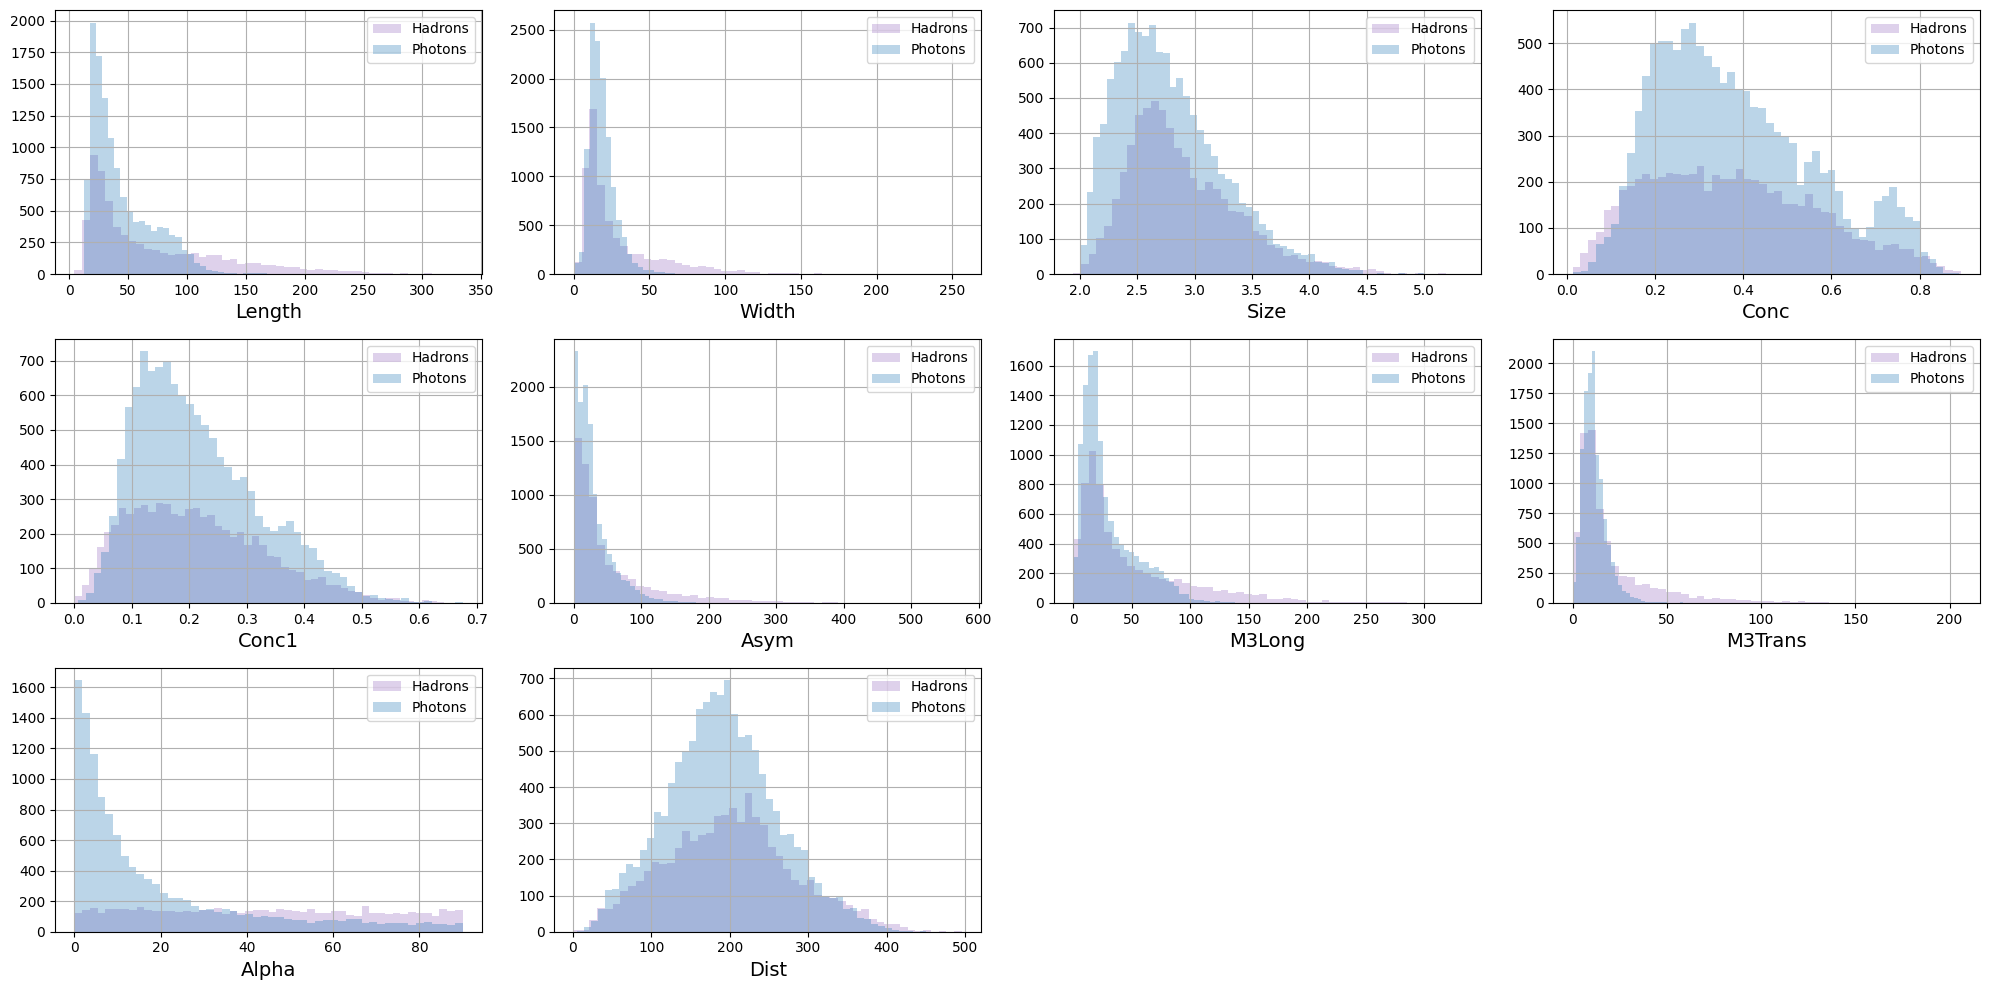

In [158]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [159]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=RANDOM_STATE
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

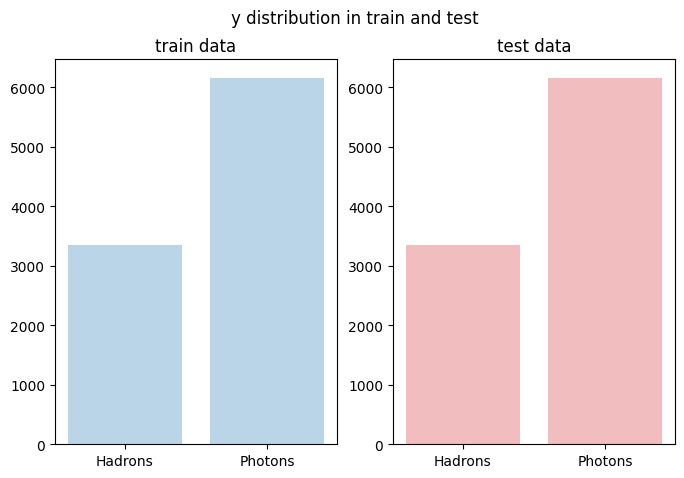

In [160]:
labels = ['Hadrons', 'Photons']
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
fig.suptitle('y distribution in train and test')

values1, counts1 = np.unique(y_train, return_counts=True)
axs[0].set_title('train data')
axs[0].bar(labels, counts1, alpha=0.3, color='C0')

values2, counts2 = np.unique(y_test, return_counts=True)
axs[1].set_title('test data')
axs[1].bar(labels, counts2, alpha=0.3, color='C3')

plt.show()

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [161]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

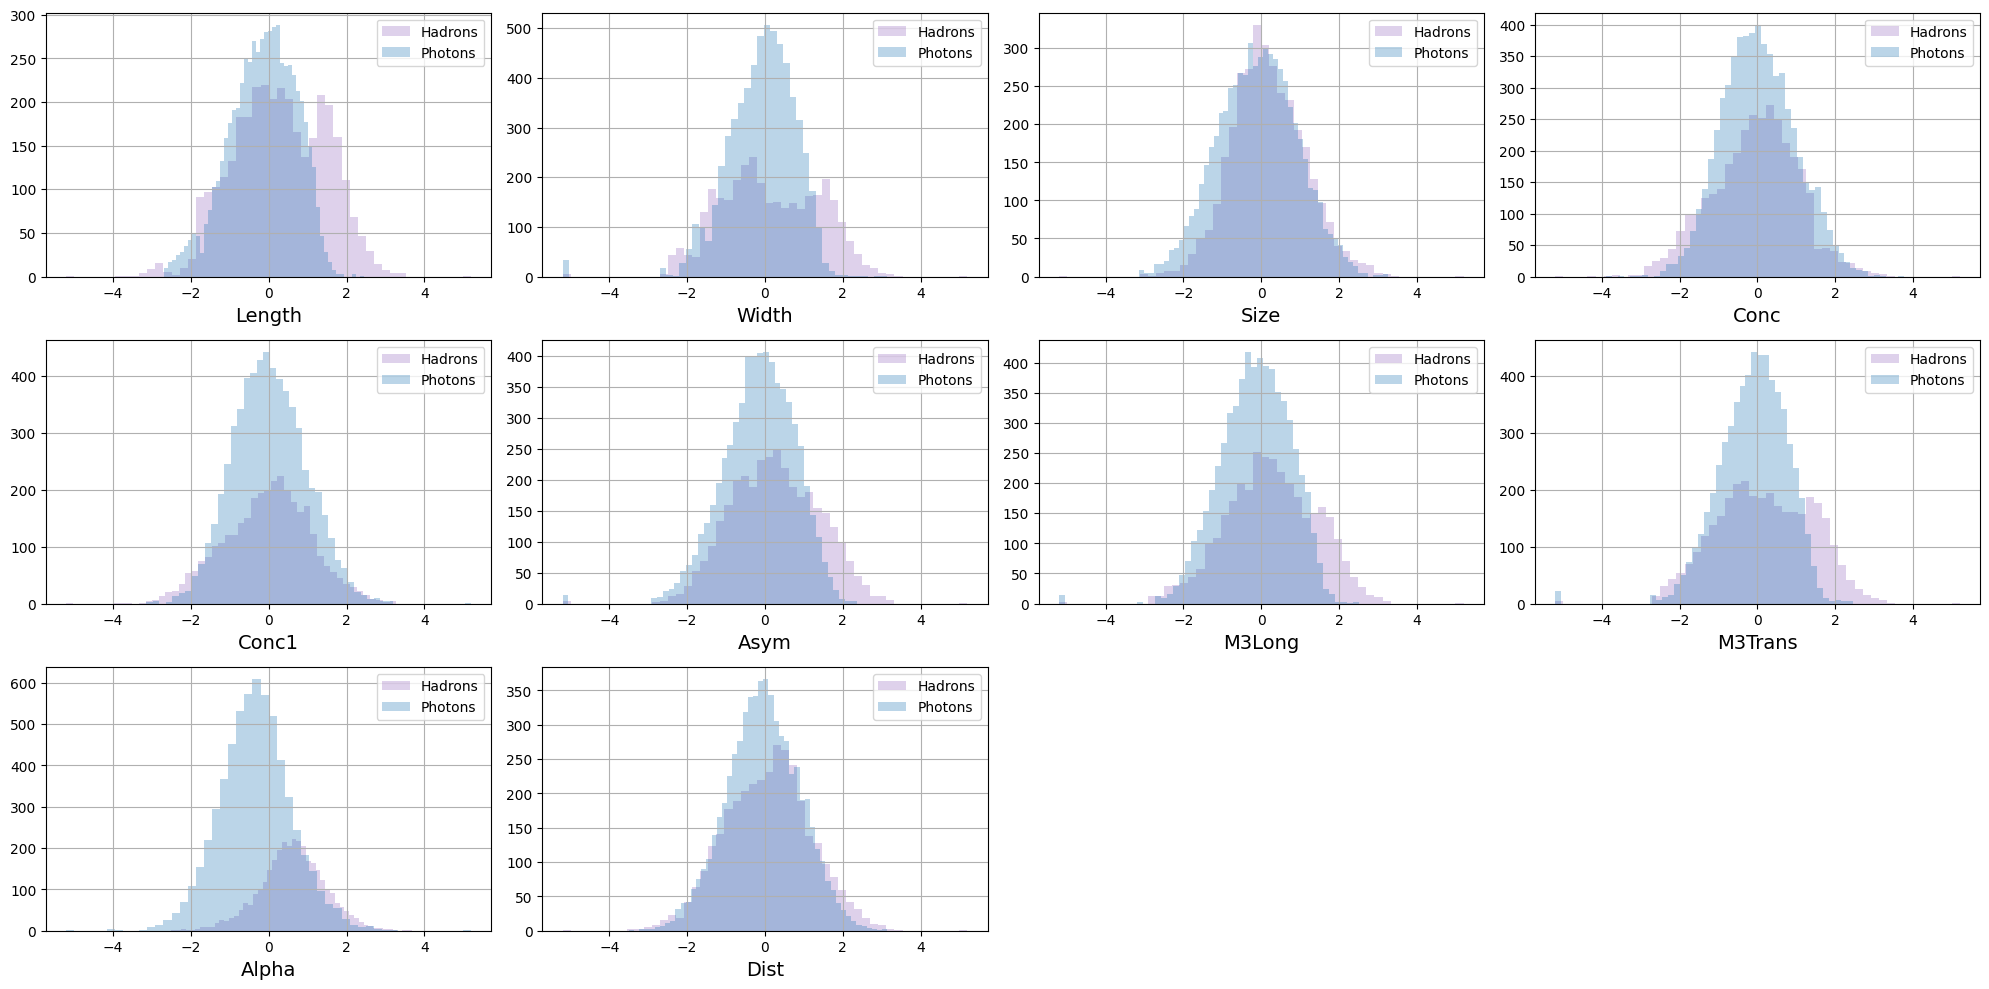

In [162]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

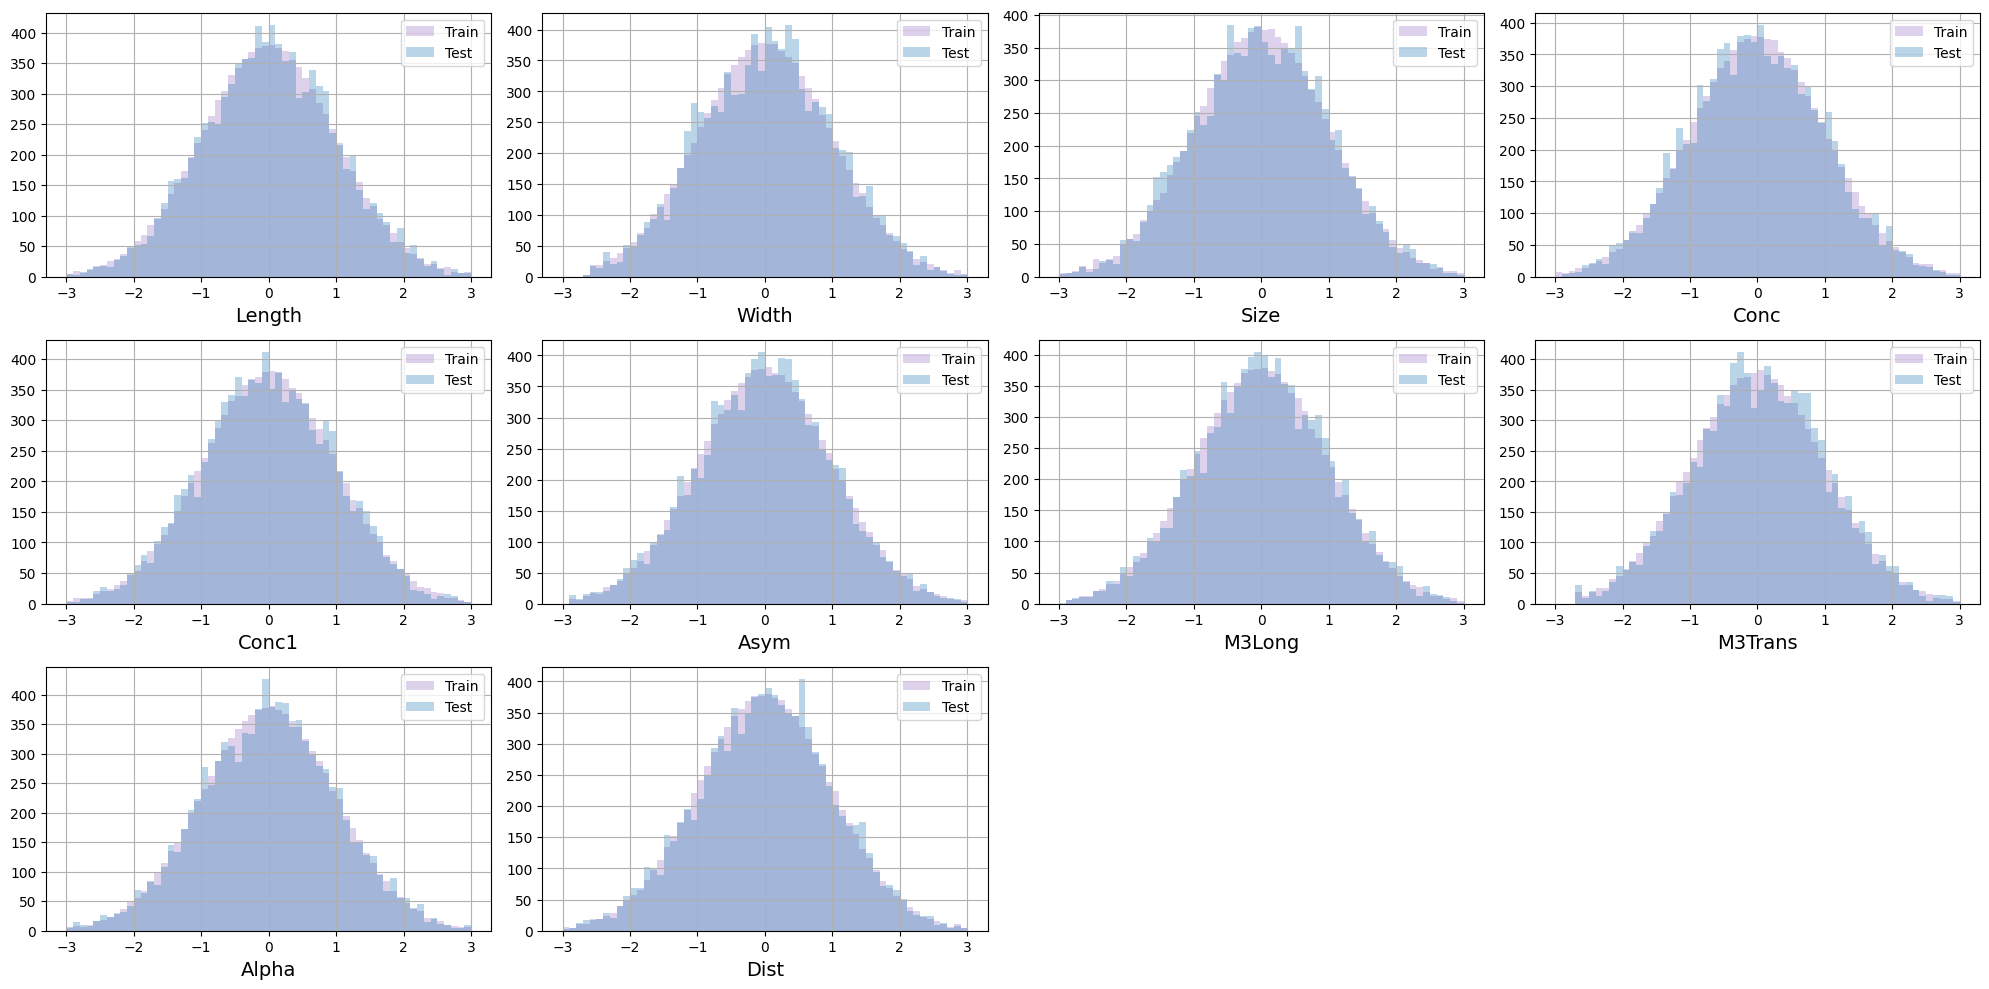

In [163]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/cgan.png?raw=1" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [164]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [165]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [166]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden=100):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_outputs),
        )


    def forward(self, z, y):
        y = torch.tensor(y, dtype=torch.float, device=DEVICE)
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [167]:
def generate(generator, y, latent_dim):
    Z_noise = torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE)

    with torch.no_grad():
      X_fake = generator.forward(Z_noise, y)

    return X_fake.cpu().numpy()

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [168]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs, hidden=100):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1))


    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

в конце работы WGAN не должно быть функции активации - ее особенность в том, что выход не ограничивается значением от 0 до 1.  [Instead, the WGAN discriminator networks return a value in a range, which allows it to act less strictly as a critic.](https://blog.paperspace.com/wgans/)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X_real_train, X_real_test, y_real_train, y_real_test = train_test_split(
        X_real, y_real, stratify=y_real, test_size=0.25, shuffle=True, random_state=RANDOM_STATE
        )
    X_fake_train, X_fake_test, y_fake_train, y_fake_test = train_test_split(
        X_fake, y_fake, stratify=y_fake, test_size=0.25, shuffle=True, random_state=RANDOM_STATE
        )

    # concat axis 0 - vstack, concat axis1 - hstack
    # concat fake and real objects after splitting them in order to keep the balance between them
    X_train = np.concatenate((X_real_train, X_fake_train), axis=0)
    X_test = np.concatenate((X_real_test, X_fake_test), axis=0)

    y_train = np.concatenate((y_real_train, y_fake_train), axis=0)
    y_test = np.concatenate((y_real_test, y_fake_test), axis=0)

    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    log_reg_pred = log_reg.predict(X_test)
    log_reg_score = accuracy_score(y_test, log_reg_pred)

    boosting = GradientBoostingClassifier()
    boosting.fit(X_train, y_train)
    boosting_pred = boosting.predict(X_test)
    boosting_score = accuracy_score(y_test, boosting_pred)

    print("Linear regression score: " + str(log_reg_score))
    print("Boosting score: " + str(boosting_score))

accuracy говорит о том, сколько картинок из их общего числа были классифицированы верно.

если у нашего классификатора (дискриминатора) будет очень высокий accuracy score, то есть если он будет очень хорошо различать реальные и фейковые объекты, тогда его выход не будет информативным для генератора, а мы заинтересованы, чтобы с каждой итерацией генератор улучшался и генерировал более реалистичные объекты.

наверное, нельзя говорить о желаемом скоре дискриминатора, ничего не зная о качестве генератора и о других метриках вообще. если сгенерированные объекты совсем или немного нереалистичные, а accuracy дискиминатора имеет большое значение, то это плохо, т.к. генератору надо доучиваться, а не на чем. если сгенерированные объекты очень близки к реальным, то высокий accuracy score будет лишь означать, что обучение можно завершать.

подытоживая, accuracy score < 0.5 звучит плохо, 0.6-0.8 хорошо для середины обучения, 0.9 и выше для конца обучения, когда генератор справляется с задачей создания  объектов, похожих на реальные.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [170]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

              Z_noise = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
              X_fake = self.generator(Z_noise, cond_batch)

              # train discriminator
              for i in range(self.n_critic):
                self.opt_disc.zero_grad()

                loss_disc = (-torch.mean(self.discriminator(real_batch, cond_batch))
                              + torch.mean(self.discriminator(X_fake, cond_batch)))
                loss_disc.backward(retain_graph=True)

                for p in self.discriminator.parameters():
                  p.data.clamp_(-0.01, 0.01)

                self.opt_disc.step()

              # train generator
              self.opt_gen.zero_grad()

              loss_gen = (torch.mean(self.discriminator(real_batch, cond_batch))
                            - torch.mean(self.discriminator(X_fake, cond_batch)))
              loss_gen.backward(retain_graph=True)

              self.opt_gen.step()

            # calculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # create 2 sample consisting of 1000 (real and fake) objects
            sample_size = 1000
            real_sample = X_train[:sample_size]
            fake_sample = generate(self.generator, y_cond[:sample_size], self.latent_dim)
            score = other_agent_score(real_sample, torch.ones(sample_size), fake_sample, np.zeros(sample_size))

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [171]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.55
Boosting score: 0.714
Linear regression score: 0.58
Boosting score: 0.706
Linear regression score: 0.524
Boosting score: 0.708
Linear regression score: 0.606
Boosting score: 0.708
Linear regression score: 0.55
Boosting score: 0.714
Linear regression score: 0.524
Boosting score: 0.684
Linear regression score: 0.564
Boosting score: 0.674
Linear regression score: 0.562
Boosting score: 0.654
Linear regression score: 0.508
Boosting score: 0.642
Linear regression score: 0.586
Boosting score: 0.656
Linear regression score: 0.516
Boosting score: 0.634
Linear regression score: 0.542
Boosting score: 0.602
Linear regression score: 0.514
Boosting score: 0.662
Linear regression score: 0.526
Boosting score: 0.61
Linear regression score: 0.48
Boosting score: 0.624
Linear regression score: 0.516
Boosting score: 0.614
Linear regression score: 0.528
Boosting score: 0.632
Linear regression score: 0.476
Boosting score: 0.634
Linear regression score: 0.568
Boosting score: 0.63

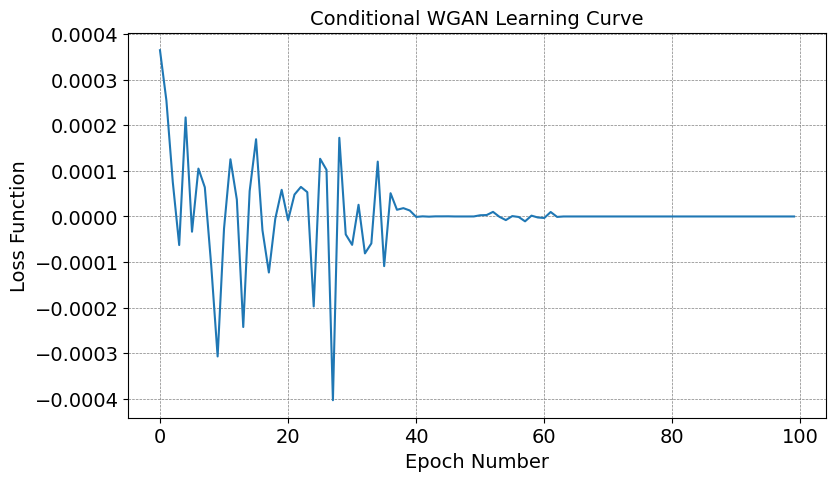

In [172]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [173]:
X_train = transformer.inverse_transform(X_train)
X_test = transformer.inverse_transform(X_test)

In [174]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = transformer.inverse_transform(X_fake_train)

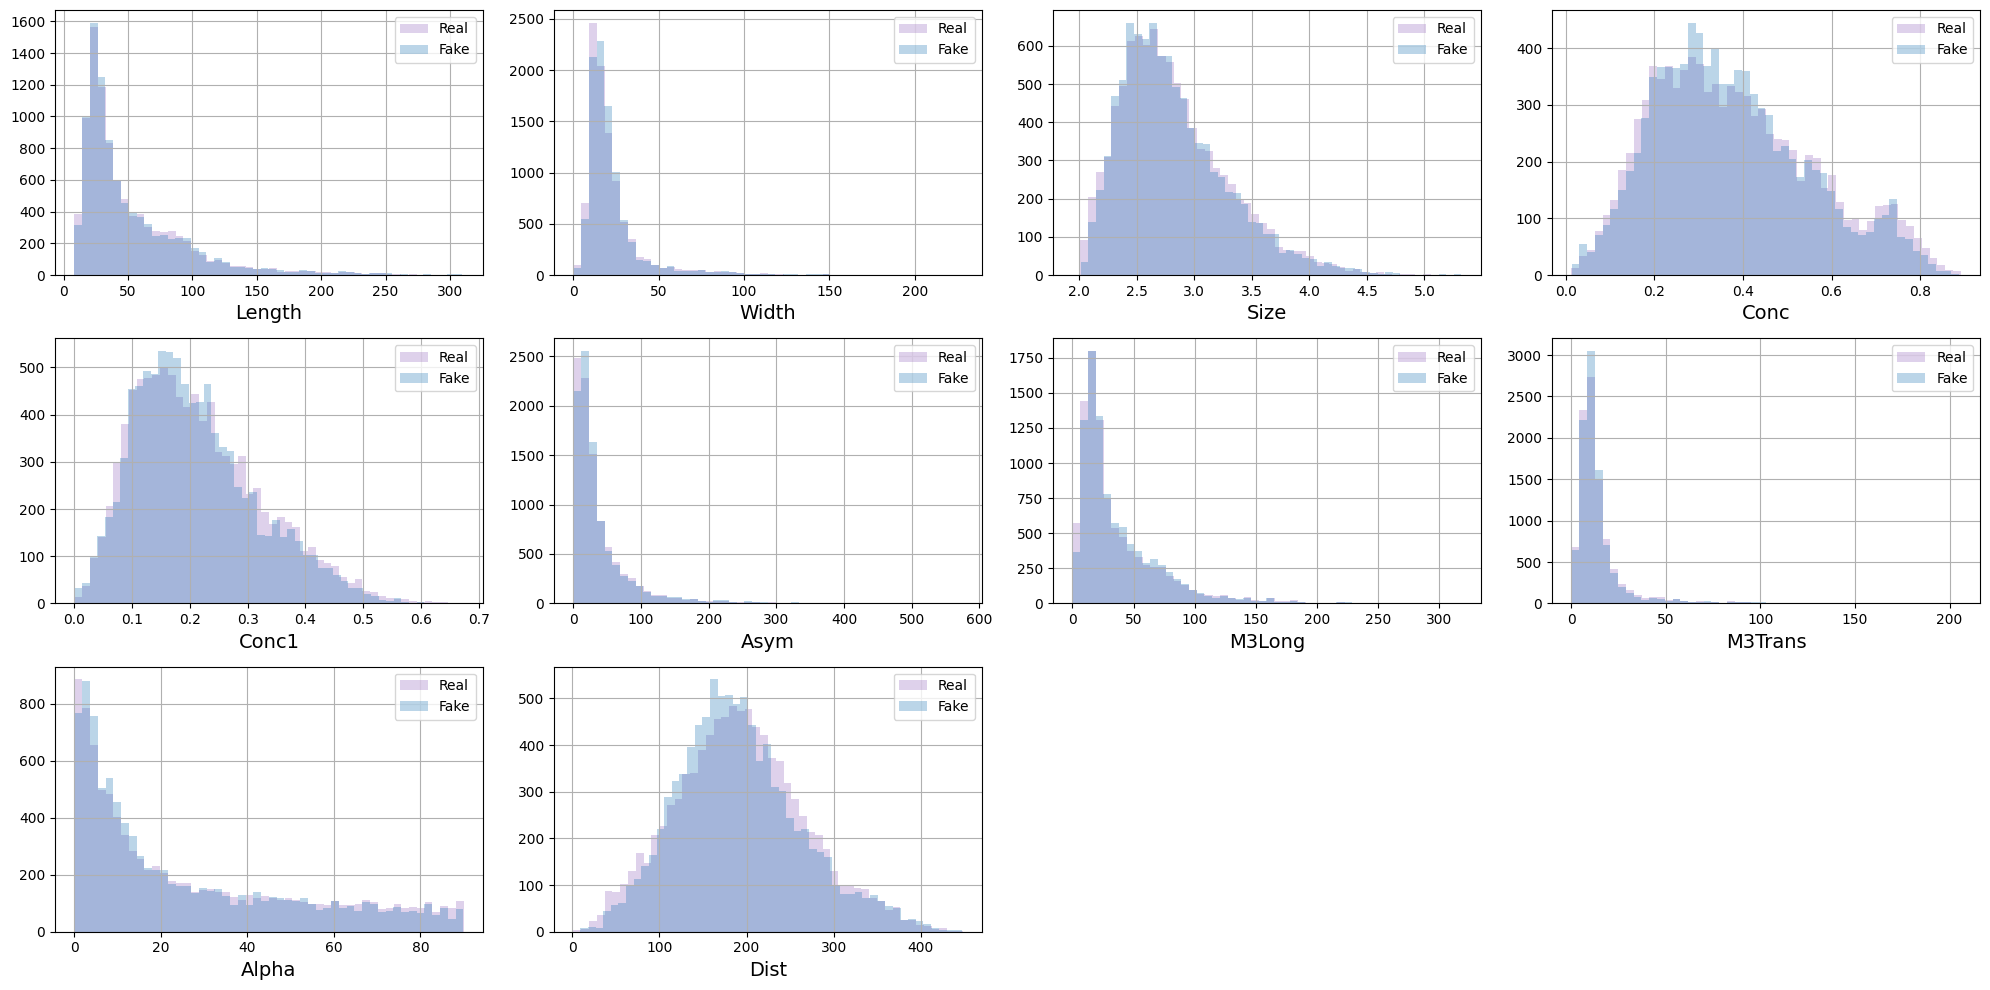

In [175]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [176]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = transformer.inverse_transform(X_fake_test)

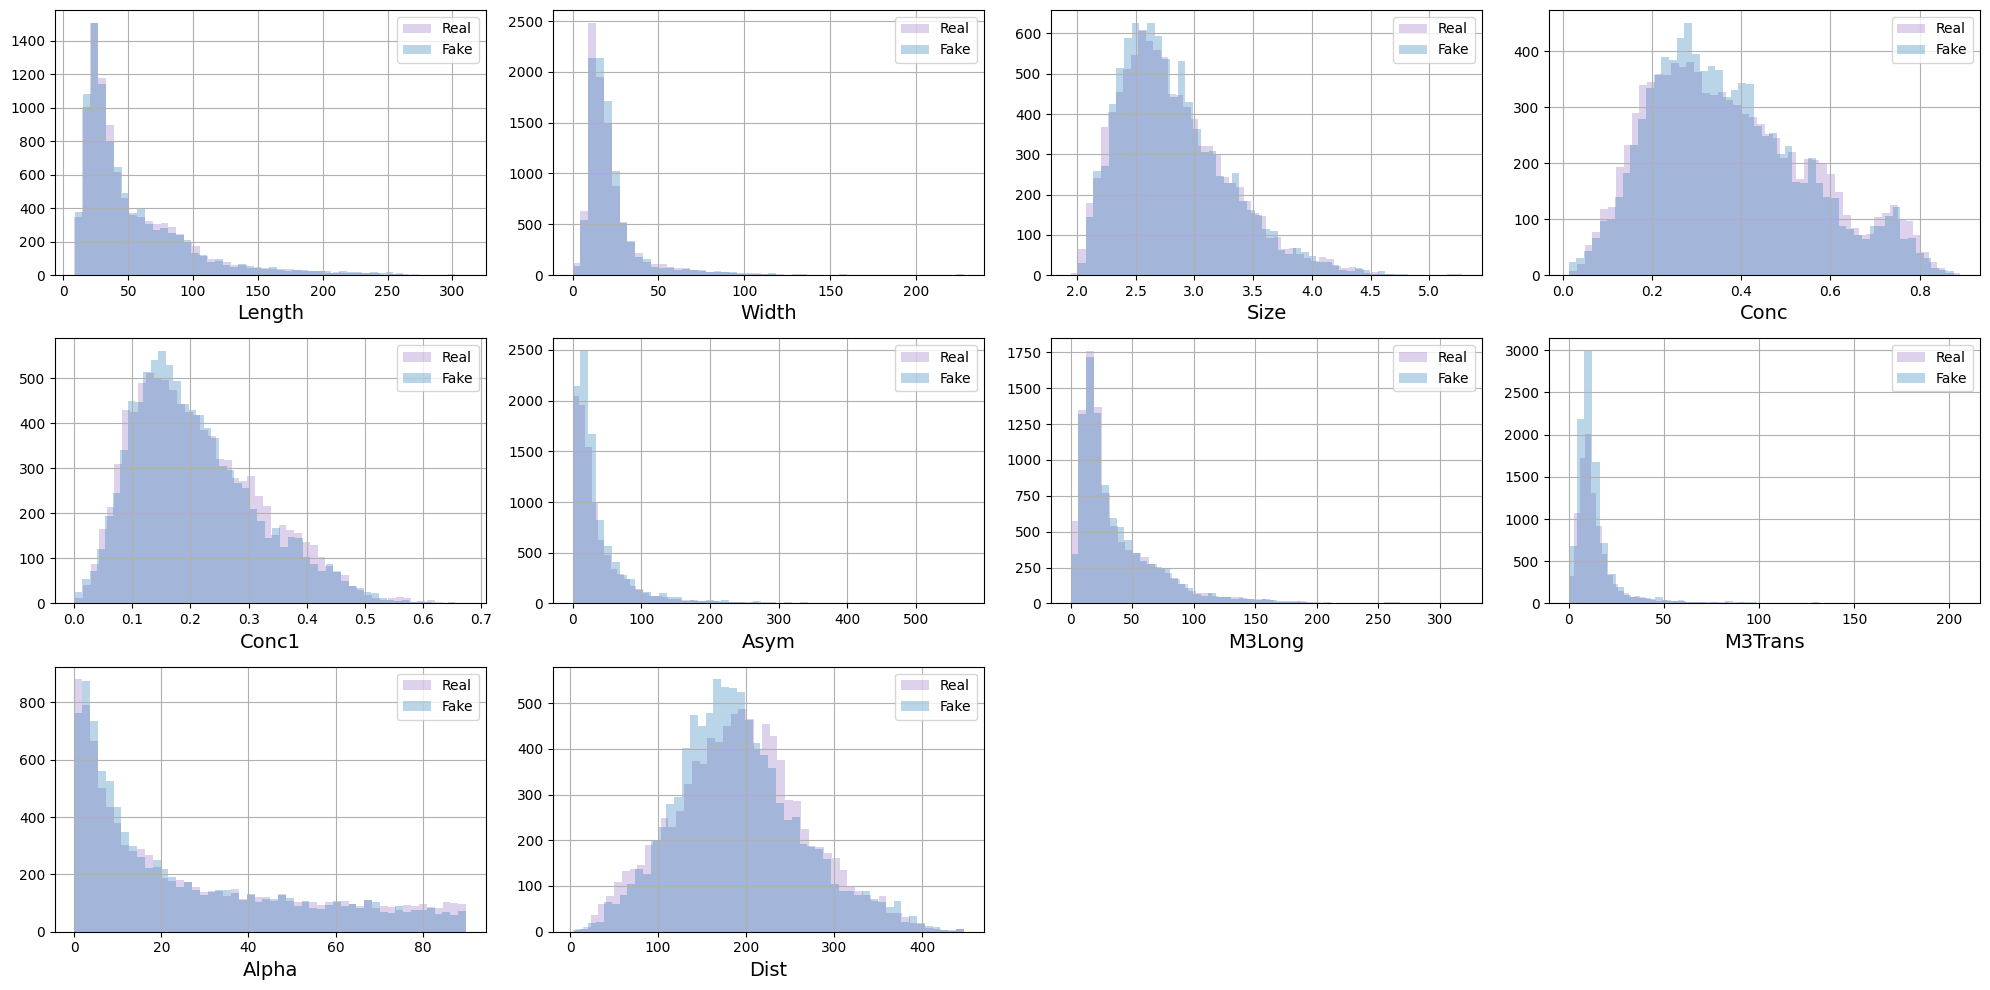

In [177]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/2024/homeworks/hw1/img/clf.png?raw=1" width="600"></center>

Измерим сходство распределений классификатором.

In [178]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [179]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [180]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.738895666855742


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

In [181]:
# вернем нормирование данных
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)

X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [182]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    """
    Corrupt the input `x` by mixing it with noise according to `amount`
    :param amount: torch.Tenosr of shape [x.shape[1], x.shape[2], x.shape[3]]
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

## Добавим sсheduler, он пригодится вам при обучении модели

In [183]:
!pip install diffusers -q
from diffusers import DDPMScheduler

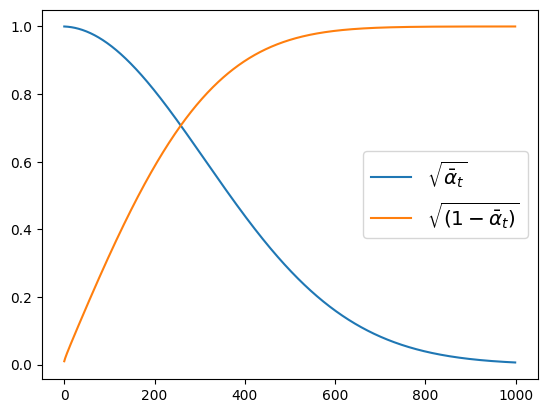

In [184]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [185]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs, hidden=100):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_outputs)
            )


    def forward(self, z, y):
        y = torch.tensor(y, dtype=torch.float, device=DEVICE)
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [186]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    Z_noise = torch.normal(0, 1, (len(y), latent_dim), device=DEVICE)

    with torch.no_grad():
        X_fake = model(Z_noise, y)

    noise = torch.randn_like(X_fake).to(DEVICE)
    timesteps = torch.randint(0, 999, (X_fake.shape[0],)).long().to(DEVICE)
    X_fake = scheduler.add_noise(X_fake, noise, timesteps)
    return X_fake.cpu().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [187]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                self.opt_gen.zero_grad()

                Z_noise = torch.normal(0, 1, (len(real_batch), latent_dim)).to(DEVICE)
                X_fake = self.model(Z_noise, cond_batch)

                noise = torch.randn_like(X_fake)
                timesteps = torch.randint(0, 999, (X_fake.shape[0],)).long().to(DEVICE)
                X_noisy = noise_scheduler.add_noise(X_fake, noise, timesteps)

                loss = F.mse_loss(X_noisy, noise)
                loss.backward()

                self.opt_gen.step()

                loss_epoch += loss.item()

            # calculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # create 2 sample consisting of 1000 (real and fake) objects
            sample_size = 1000
            real_sample = X_train[:sample_size]
            fake_sample = generate_with_diffusion(self.model, y_cond[:sample_size], self.latent_dim, noise_scheduler)
            score = other_agent_score(real_sample, torch.ones(sample_size), fake_sample, np.zeros(sample_size))

        # Turn off training
        self.model.train(False)

In [188]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.55
Boosting score: 0.882
Linear regression score: 0.552
Boosting score: 0.894
Linear regression score: 0.52
Boosting score: 0.884
Linear regression score: 0.518
Boosting score: 0.916
Linear regression score: 0.522
Boosting score: 0.902
Linear regression score: 0.486
Boosting score: 0.896
Linear regression score: 0.516
Boosting score: 0.87
Linear regression score: 0.486
Boosting score: 0.89
Linear regression score: 0.482
Boosting score: 0.89
Linear regression score: 0.506
Boosting score: 0.906
Linear regression score: 0.532
Boosting score: 0.904
Linear regression score: 0.524
Boosting score: 0.884
Linear regression score: 0.492
Boosting score: 0.892
Linear regression score: 0.54
Boosting score: 0.906
Linear regression score: 0.498
Boosting score: 0.878
Linear regression score: 0.516
Boosting score: 0.904
Linear regression score: 0.484
Boosting score: 0.9
Linear regression score: 0.552
Boosting score: 0.888
Linear regression score: 0.492
Boosting score: 0.884
L

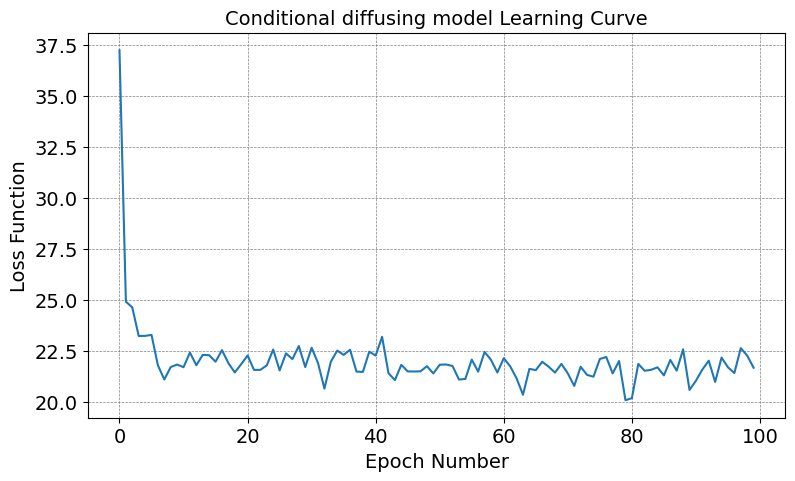

In [189]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [190]:
X_train = transformer.inverse_transform(X_train)
X_test = transformer.inverse_transform(X_test)

In [191]:
X_fake_train = generate_with_diffusion(fitter.generator, y_train, latent_dim, noise_scheduler)
X_fake_train = transformer.inverse_transform(X_fake_train)

X_fake_test = generate_with_diffusion(fitter.generator, y_train, latent_dim, noise_scheduler)
X_fake_test = transformer.inverse_transform(X_fake_test)

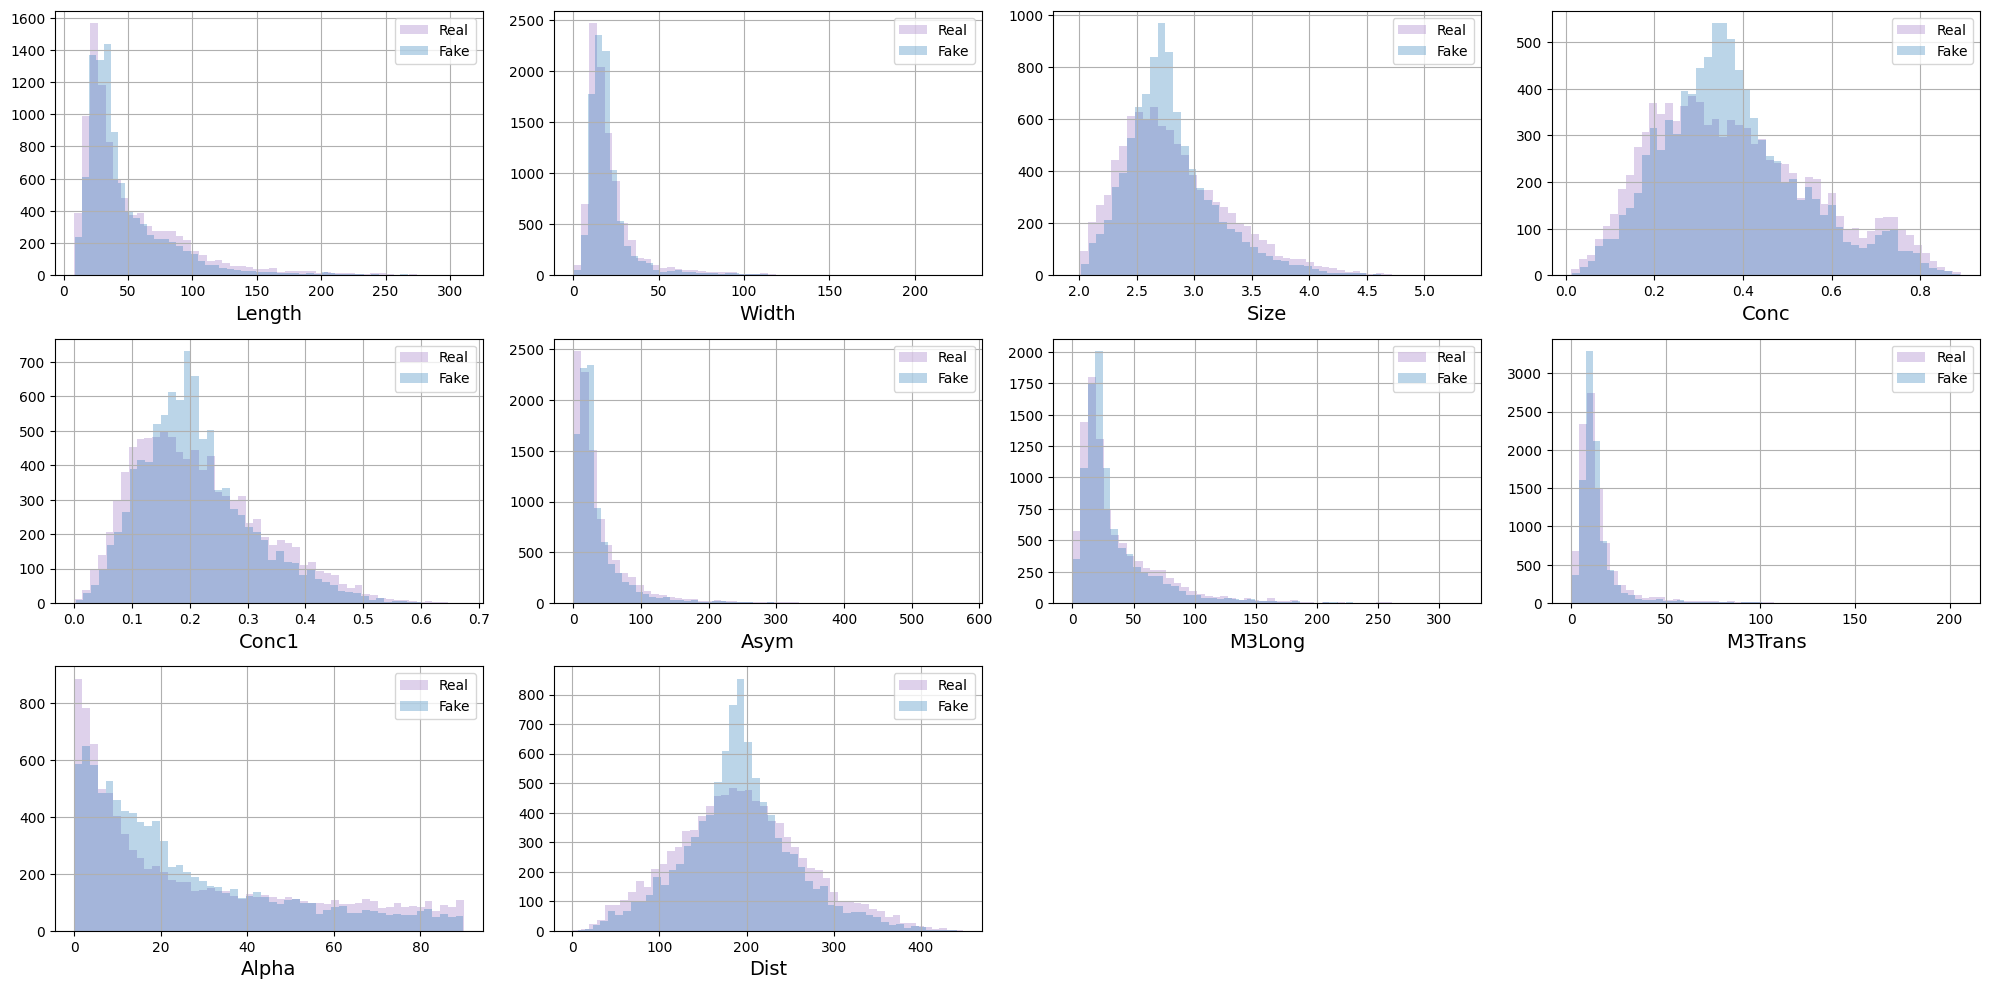

In [192]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

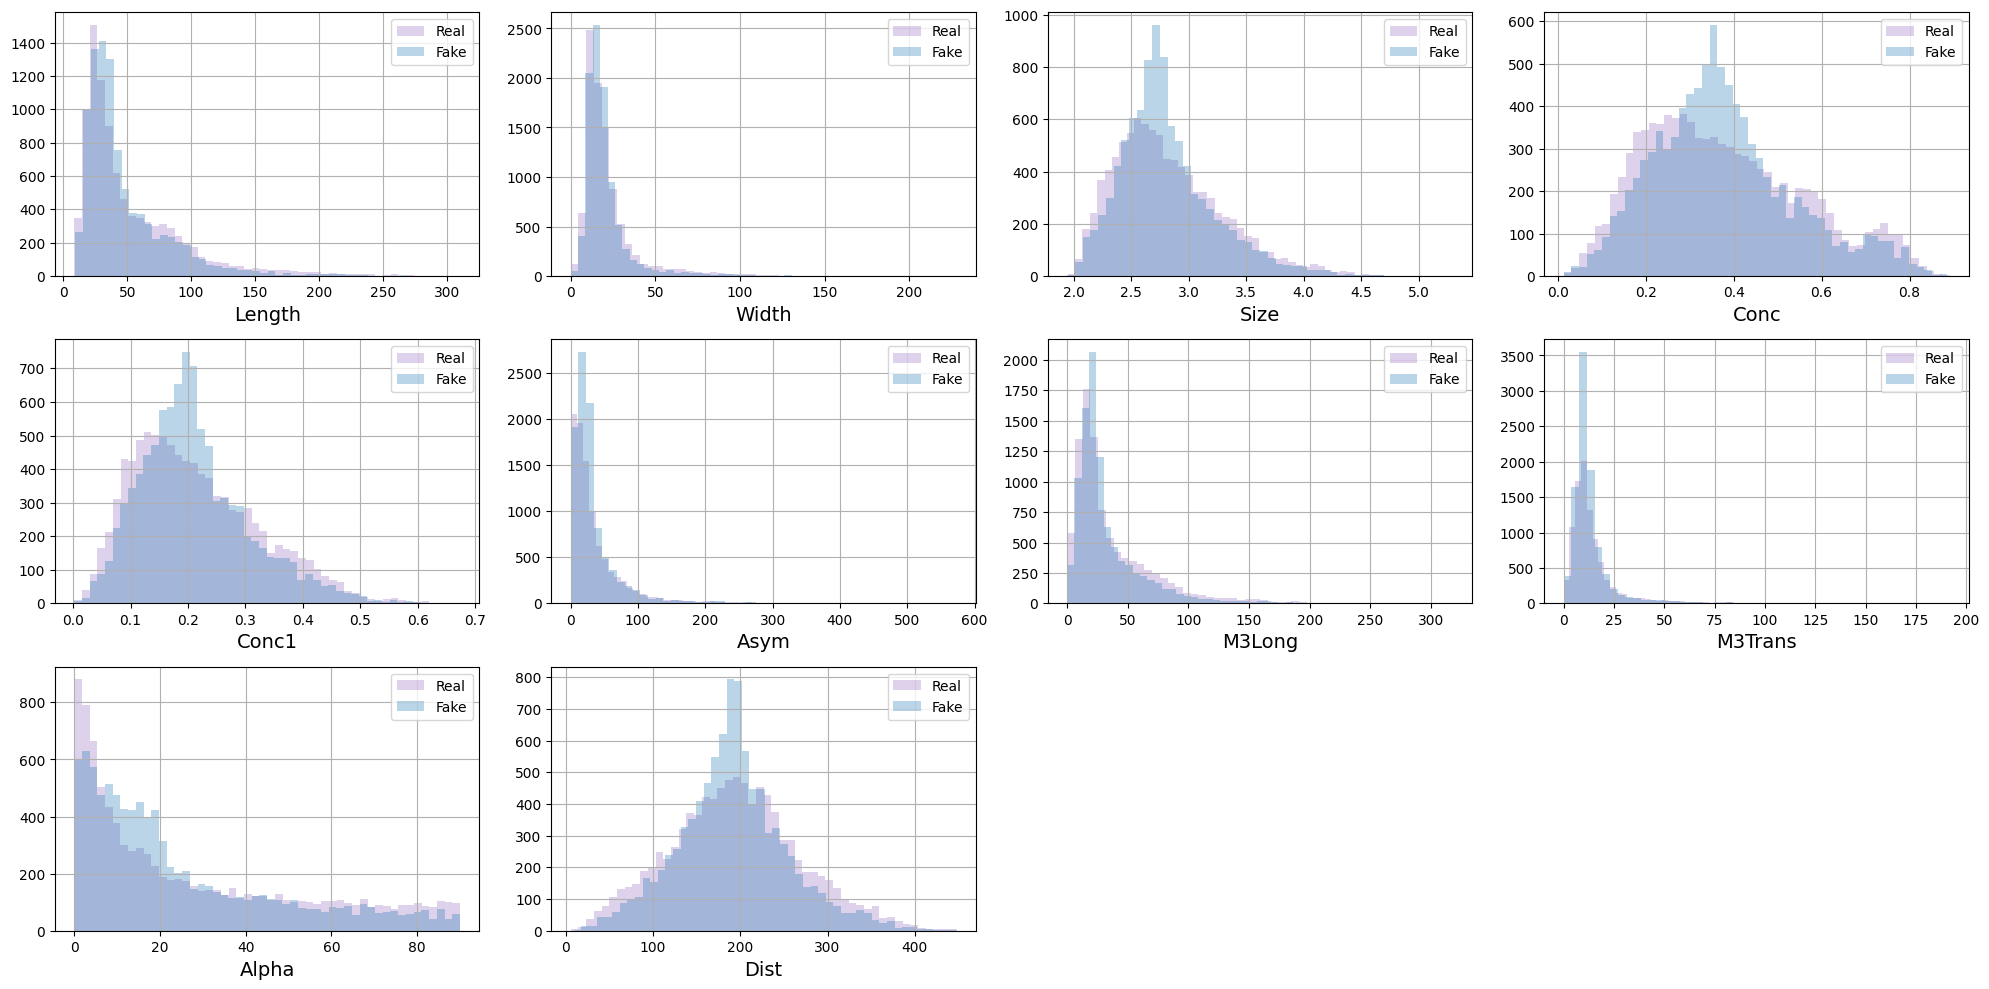

In [193]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [194]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [195]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]
yy_test_pred = clf.predict(XX_test)

In [196]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

auc = roc_auc_score(yy_test, yy_test_proba)
acc = accuracy_score(yy_test, yy_test_pred)
print("ROC AUC = ", auc)
print('Accuracy =', acc)

ROC AUC =  0.9764630512350163
Accuracy = 0.9187171398527866


если честно, подзапуталась, почему в общем чате говорят о переобучении модели ... да, отдельный рок-аук, равный почти 1, звучит как переобучение, но с высоким accuracy и полученным распределением выглядит так, будто генерируются данные, похожие на реальные, а также хорошо (но Неидеально) работает дискриминатор. поэтому хочется сказать, что кач-во у модели хорошее ..

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!